### DNN기반 이진분류 모델 구현 및 학습 모니터링과 저장
- 데이터셋  : iris.csv
- 피쳐/속성 : 3개 (Sepal_Length, Sepal_Width, Petal_Length, Petal_Width)
- 타겟/라벨 : 1개 (Variety)
- 학습 방법 : 지도학습 > 분류
- 알고리즘  : 인공신경망(ANN) -> MLP, DNN : 은닉층이 많은 구성
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [57]:
# 모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

# Data 및 시각화 관련
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [58]:
# 활용 패키지 버전 체크 ==> 사용자 정의함수로 구현하세요~
print(f'Pytorch v.{torch.__version__}')
print(f'pandas v.{pd.__version__}')

Pytorch v.2.4.1
pandas v.2.0.3


In [59]:
# 데이터 로딩
DATA_FILE = '../../../Data/iris.csv'

# CSV >>> DataFrame
irisDF = pd.read_csv(DATA_FILE)

# 확인
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


In [60]:
# 타겟 변경 => 정수화, 클래스 3개 => 2개
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [61]:
# 클래스 3개 => 2개
irisDF['variety'] = (irisDF['variety'] == 'Setosa').astype('int')
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,1


In [62]:
print(f"고유값 : {irisDF['variety'].unique()}")

고유값 : [1 0]


[2] 모델 클래스 설계 및 정의 <hr>
- 클래스 목적 : iris 데이터를 학습 및 추론 목적
- 클래스 이름 : IrisBCFModel
- 부모 클래스 : nn.Module
- 매개   변수 : 층별 입출력 개수 고정하기 때문에 필요 없음
- 속성 / 필드 :
- 기능 / 역할 : \__init__() : 모델 구조 설정, forward() : 순방향 학습 <= 오버라이딩(overriding)

- 클래스 구조
    * 입력층 :
        * 입력 4개(피쳐)
        * 출력 10개(퍼셉트론/뉴런 10개 존재)
    * 은닉층 :
        * 입력 10개
        * 출력 5개(퍼셉트론/뉴런 30개 존재)
    * 출력층 :
        * 입력 5개
        * 출력 1개(퍼셉트론/뉴런 1개 존재 : 2진분류)

- 손실함수/활성화함수
    * 클래스 형태 ==> nn.MSELoss, nn.ReLU ==> init() 메서드
    * 함수 형태 ==> torch.nn.functional 아래에 ==> forward() 메서드

In [63]:
class IrisBCFModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer = nn.Linear(4, 10)
        self.hidden_layer = nn.Linear(10, 5)
        self.out_layer = nn.Linear(5, 1)

    # 순방향 학습 진행 메서드
    def forward(self, input_data):
        # 입력층
        y = self.in_layer(input_data)
        y = F.relu(y)

        # 은닉층 : 10개의 숫자 값(>=0)
        y = self.hidden_layer(y)
        y = F.relu(y)

        # 출력층 : 5개의 숫자 값 => 이진분류
        return F.sigmoid(self.out_layer(y))

In [64]:
# 모델 인스턴스 생성
model = IrisBCFModel()

print(model)

IrisBCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [65]:
# 모델 사용
summary(model, input_size=(17,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisBCFModel                             [17, 1]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 1]                   6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐 개수 : 4개
- 타겟 개수 : 1개
- 클래스 이름 : IrisDataset
- 부모 클래스 : utils.data.Dataset
- 속성 필드 : featureDF, targetDF, n_rows, n_features
- 필수 메서드
    * \__init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * \__len__(self) : 데이터의 개수 반환
    * \__getitem__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [66]:
class IrisDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values)
        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [67]:
# [테스트] 데이터셋 인스턴스 생성

# DataFrame에서 피쳐와 타겟 추출
featureDF = irisDF[irisDF.columns[:-1]] # 2D (150, 3)
targetDF = irisDF[irisDF.columns[-1:]] # 2D (150, 1)

# 커스텀 데이터셋 인스턴스
irisDS = IrisDataset(featureDF, targetDF)

# 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


[4] 학습 준비
- 학습 횟수 : EPOCH (처음부터 끝까지 학습하는 단위)
- 배치 크기 : BATCH_SIZE (한 번에 학습할 데이터셋 양)
- 위치 지정 : DEVICE (텐서 저장 및 실행 위치 : GPU/CPU) 
- 학습률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001 ~ 0.1

In [68]:
# 학습 진행 관련 설정
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (, 손실함수, 성능지표)

In [69]:
# 모델 인스턴스
model = IrisBCFModel()

# DS와 DL 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF,
                                                    random_state=1, stratify=targetDF)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  random_state=1, stratify=y_train)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()/y_train.shape[0]} {y_test.value_counts()/y_test.shape[0]} {y_val.value_counts()/y_val.shape[0]}')
print(f'{type(y_train)} {type(y_test)} {type(y_val)}')

# 학습용, 검증용, 테스트용 데이터셋
trainDS = IrisDataset(X_train, y_train)
valDS  = IrisDataset(X_val, y_val)
testDS = IrisDataset(X_test, y_test)

# 학습용 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, drop_last=True)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
variety
0          0.666667
1          0.333333
Name: count, dtype: float64 variety
0          0.657895
1          0.342105
Name: count, dtype: float64 variety
0          0.678571
1          0.321429
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [70]:
# [테스트] 데이터로더
for feature, target in trainDL:
    print(feature.shape, target.shape, sep='\n')
    break

torch.Size([10, 4])
torch.Size([10, 1])


- 최적화 손실함수 인스턴스

In [71]:
# 최적화 인스턴스 => W, b 텐서 즉, model.parameters() 전달
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss => BCELoss
#                              예측값은 확률값으로 전달 ==> sigmoid() AF 처리 후 전달
regLoss = nn.BCELoss()

[5] 학습 진행

> 모델 저장 관련 준비

In [72]:
# models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
import os 

# 저장 경로
SAVE_PATH = 'models/BCF/'
# 저장 파일명
SAVE_FILE = SAVE_PATH+'model_train_wbs.pth'
# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL = SAVE_PATH+'model_all.pth'

In [73]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH) # 폴더 생성

In [74]:
# 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY = [[],[]], [[],[]]
CNT = len(trainDL)
print(f"BATCH_CNT => {CNT}")

# 학습 모니터링/스케쥴링 설정
# => LOSS_HISTORY, SCORE_HISTORY 활용
# => 임계기준 : 10번
BREAK_CNT_LOSS = 0
BREAK_CNT_SCORE = 0
LIMIT_VALUE = 10

for epoch in range(EPOCH):
    # 학습 모드로 모델 설정
    model.train()

    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total = 0, 0

    for featureTS, targetTS in trainDL:
        # 학습 진행
        pred_y = model(featureTS)

        # 손실 계산
        loss = regLoss(pred_y, targetTS)
        loss_total += loss.item()

        # 성능평가 계산
        score = BinaryF1Score()(pred_y, targetTS)
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()

    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS = torch.FloatTensor(valDS.featureDF.values)
        val_targetTS = torch.FloatTensor(valDS.targetDF.values)

        # 추론/평가
        pred_test_y = model(val_featureTS)
        # 손실 계산
        loss_val = regLoss(pred_test_y, val_targetTS)
        # 성능 평가
        score_val = BinaryF1Score()(pred_test_y, val_targetTS)

    

    # 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/len(trainDL))
    SCORE_HISTORY[0].append(score_total/len(trainDL))

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')

    # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
    # Score 기준
    if len(SCORE_HISTORY[1]) >= 2:
        if SCORE_HISTORY[1][-1] >= SCORE_HISTORY[1][-2]: BREAK_CNT_SCORE += 1

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wbs_{epoch}_{score_val:.4f}.pth'
    if len(SCORE_HISTORY[1]) == 1:
        # 첫 번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_MODEL)
    else:
        if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)
    
    # 학습 중단 여부 설정
    if BREAK_CNT_LOSS > LIMIT_VALUE:
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break

BATCH_CNT => 8
[0/1000]
- [TRAIN] LOSS : 0.6585610434412956 SCORE : 0.0
- [VALID] LOSS : 0.6540047526359558 SCORE : 0.0
[1/1000]
- [TRAIN] LOSS : 0.6496529877185822 SCORE : 0.0
- [VALID] LOSS : 0.6430274248123169 SCORE : 0.0
[2/1000]
- [TRAIN] LOSS : 0.6404000073671341 SCORE : 0.0
- [VALID] LOSS : 0.6347092986106873 SCORE : 0.0
[3/1000]
- [TRAIN] LOSS : 0.6338707730174065 SCORE : 0.0
- [VALID] LOSS : 0.6272355318069458 SCORE : 0.20000000298023224
[4/1000]
- [TRAIN] LOSS : 0.6273306831717491 SCORE : 0.19583333656191826
- [VALID] LOSS : 0.6202901005744934 SCORE : 0.7142857313156128
[5/1000]
- [TRAIN] LOSS : 0.620634950697422 SCORE : 0.716369055211544
- [VALID] LOSS : 0.6132011413574219 SCORE : 0.9411764740943909
[6/1000]
- [TRAIN] LOSS : 0.6138594523072243 SCORE : 0.9821428582072258
- [VALID] LOSS : 0.6061477661132812 SCORE : 1.0
[7/1000]
- [TRAIN] LOSS : 0.6071221083402634 SCORE : 1.0
- [VALID] LOSS : 0.5991992950439453 SCORE : 1.0
[8/1000]
- [TRAIN] LOSS : 0.600418396294117 SCORE : 1.0

[31/1000]
- [TRAIN] LOSS : 0.43864182382822037 SCORE : 1.0
- [VALID] LOSS : 0.42750459909439087 SCORE : 1.0
[32/1000]
- [TRAIN] LOSS : 0.4316379390656948 SCORE : 1.0
- [VALID] LOSS : 0.4209011495113373 SCORE : 1.0
[33/1000]
- [TRAIN] LOSS : 0.4246927984058857 SCORE : 1.0
- [VALID] LOSS : 0.41444703936576843 SCORE : 1.0
[34/1000]
- [TRAIN] LOSS : 0.417904544621706 SCORE : 1.0
- [VALID] LOSS : 0.40805643796920776 SCORE : 1.0
[35/1000]
- [TRAIN] LOSS : 0.41131891310214996 SCORE : 1.0
- [VALID] LOSS : 0.4016616642475128 SCORE : 1.0
[36/1000]
- [TRAIN] LOSS : 0.40509606152772903 SCORE : 1.0
- [VALID] LOSS : 0.39565470814704895 SCORE : 1.0
[37/1000]
- [TRAIN] LOSS : 0.3990357555449009 SCORE : 1.0
- [VALID] LOSS : 0.3898712694644928 SCORE : 1.0
[38/1000]
- [TRAIN] LOSS : 0.393125806003809 SCORE : 1.0
- [VALID] LOSS : 0.38417044281959534 SCORE : 1.0
[39/1000]
- [TRAIN] LOSS : 0.3874977119266987 SCORE : 1.0
- [VALID] LOSS : 0.37872499227523804 SCORE : 1.0
[40/1000]
- [TRAIN] LOSS : 0.3820818476

- 학습결과 체크 => 학습과 검증의 Loss 변화, 성능 변화

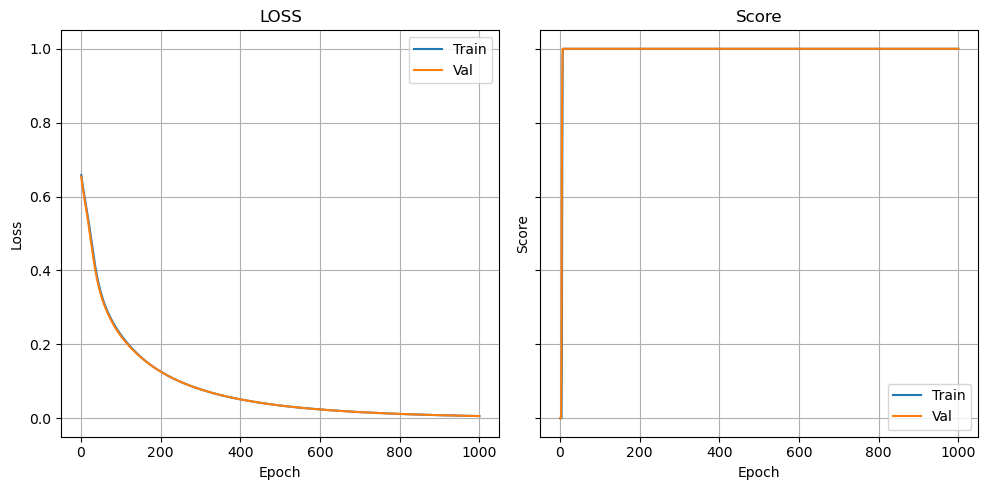

In [75]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].set_title("Score")
plt.tight_layout()
plt.show()